In [1]:
import numpy as np
from maelstrom import Maelstrom
import matplotlib.pyplot as plt


%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
plt.style.use("default")
plt.rcParams["savefig.dpi"] = 300

In [2]:
import numpy as np
from lightkurve import search_lightcurvefile

def get_lightcurve(target, **kwargs):
    lc_collection = search_lightcurvefile(target, **kwargs).download_all()

    lc = lc_collection[0].PDCSAP_FLUX.normalize()
    for l in lc_collection[1:]:
        lc = lc.append(l.PDCSAP_FLUX.normalize())

    lc = lc.remove_nans()
    #magnitude = -2.5 * np.log10(lc.flux)
    #magnitude = magnitude - np.average(magnitude)
    return lc#.time, lc.flux

lc = get_lightcurve('80 Tau', mission='TESS')
#time -= np.mean(time)
#mag *= 1000
t, y = lc.time, lc.flux
#time = time[:len(time)//2]
#mag = mag[:len(mag)//2]

In [7]:
ms = Maelstrom(t, y, max_peaks=1, fmin=10, fmax=48)
#ax = ms.plot_time_delay_periodogram(segment_size=5.5, annotate=False, max_period=300)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c24b095f8>,
      dtype=object)

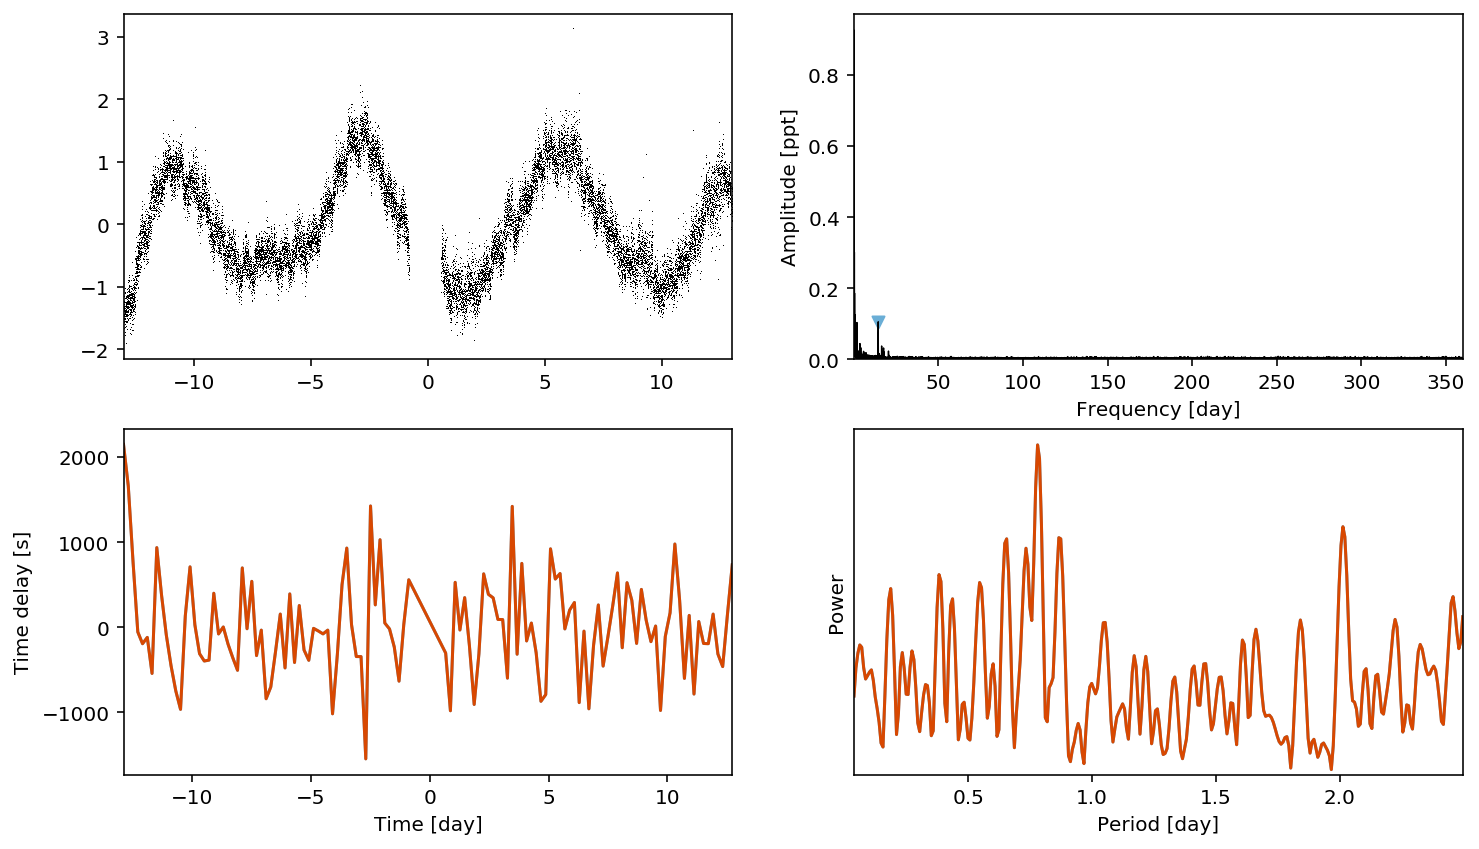

In [11]:
ms.first_look(segment_size=0.2)

In [56]:
1/0.15

6.666666666666667

In [48]:
periods = np.linspace(2, 25, 100)
pg = ms.period_search()
results = pg.fit(periods)

100%|██████████| 100/100 [05:03<00:00,  3.36s/it]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c645addd8>,
      dtype=object)

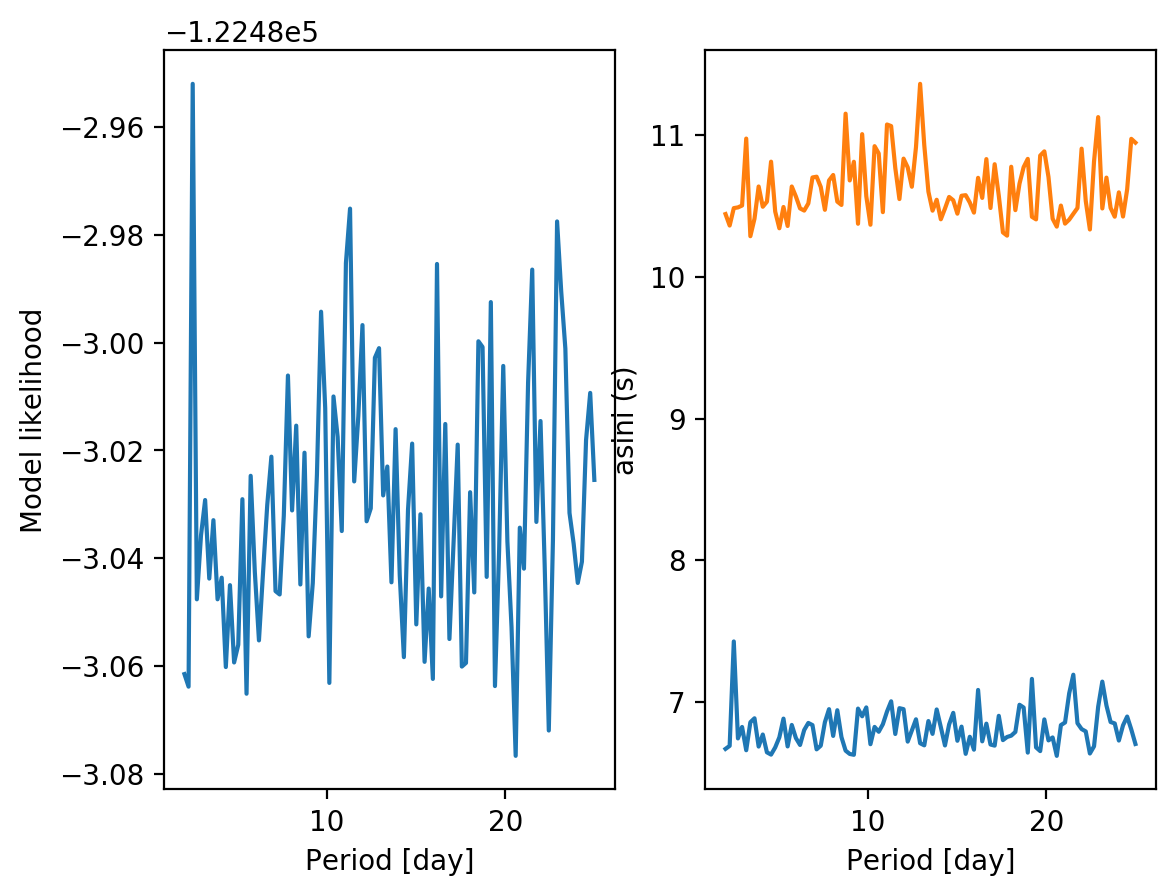

In [49]:
pg.diagnose()

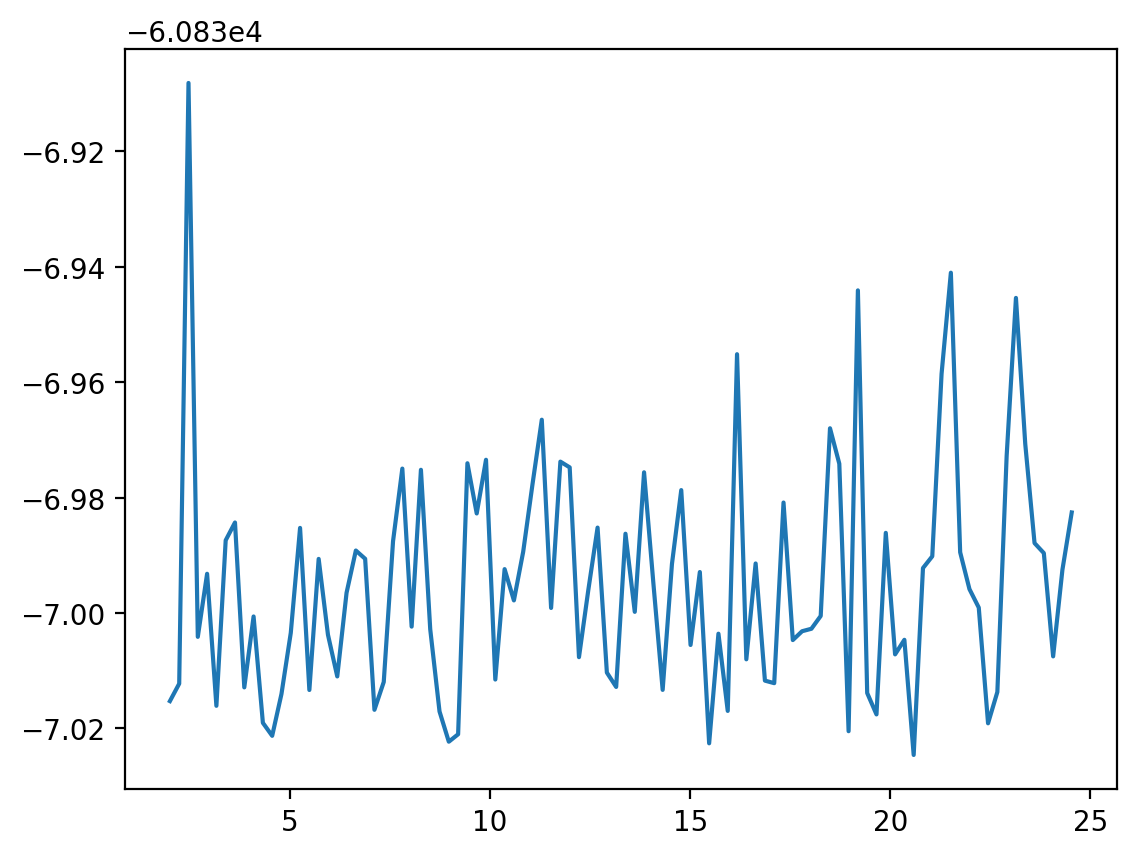

In [50]:
ys = np.array([[r[0] for r in row] for row in results])
sm = np.sum(ys, axis=0)
period_ind = np.argmax(sm)
plt.plot(periods[:-2], ys[0][:-2]);

In [5]:
time, mag = ms.time, ms.flux
freq = ms.freq

In [51]:
periods[period_ind]

2.4646464646464645

In [33]:
4.090909090909091*5

20.454545454545453

In [6]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import pymc3 as pm

with pm.Model() as model:
    # It's much faster to sample from a log-space period
#     logP = pm.Normal("logP", mu=np.log(9.15), sd=3.)
    logP = pm.Bound(pm.Normal,
                    lower=np.log(5),
                    upper=np.log(50))("logP", mu=np.log(9.15), sd=1.0,
                                      testval=np.log(9.15))
    period = pm.Deterministic("period", pm.math.exp(logP))
    # Time delay drift
    drift_gradient = 0.0
#     drift_gradient = pm.Normal('drift_grad', mu=0.0, sd=0.01, shape=len(freq))
    
    # The time of conjunction
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(mag)), sd=10, testval=0.)
    logasini = pm.Bound(pm.Normal,
                        lower=np.log(10),
                        upper=np.log(50))('logasini', mu=np.log(19.6), sd=1,
                                            testval=np.log(19.6))
    asini = pm.Deterministic("asini", tt.exp(logasini))
    
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)
    
    # Mean anom
    M = 2.0 * np.pi * time / period - phi
    psi = -tt.sin(M)
    
    # Sampling in the weights parameter is faster than solving the matrix.
    lognu = pm.Normal("lognu", mu=np.log(ms.freq), sd=0.1, shape=len(ms.freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    factor = 2. * np.pi * nu
    
    arg = ((factor * (1 - drift_gradient))[None, :] * time[:, None]
           - (factor * asini / 86400)[None, :] * psi[:, None])

    phase = xo.distributions.Angle("phase", shape=len(ms.freq))
    log_min_amp = np.log(0.1 * np.std(mag))  # np.log(np.median(np.abs(np.diff(mag))))
    log_max_amp = np.log(np.std(mag))
    log_mean_amp = 0.5*(log_min_amp + log_max_amp)
    logamp = pm.Bound(pm.Normal,
                      lower=log_min_amp,
                      upper=log_max_amp)("logamp", mu=log_mean_amp, sd=10.0, shape=len(freq),
                                         testval=log_mean_amp)
    lc_model = tt.sum(tt.exp(logamp)[None, :] * tt.sin(arg - phase[None, :]), axis=1)
        
    # GP parameters
    logw0 = pm.Bound(pm.Normal,
                     lower=np.log(2*np.pi/100.0),
                     upper=np.log(2*np.pi/0.1))("logw0", mu=np.log(2*np.pi/10), sd=10,
                                                testval=np.log(2*np.pi/10))
    logpower = pm.Normal("logpower", mu=np.log(np.var(mag)), sd=10)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    full_lc = lc_model + mean

    pm.Potential("obs", gp.log_likelihood(mag - full_lc))
#     pm.Deterministic("gp_pred", gp.predict())

    trace = pm.load_trace(directory='traces/6780873/')

In [20]:
import theano

with model:
    func = xo.utils.get_theano_function_for_var(model.logpt, profile=True)
#     func = xo.utils.get_theano_function_for_var(theano.grad(model.logpt, model.vars), profile=True)
    args = xo.utils.get_args_for_theano_function(model.test_point)
    print(func(*args))
    
    %timeit func(*args)

-419419.01525025524
10.1 ms ± 91.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
func.profile.summary()

Function profiling
  Message: /Users/danielhey/anaconda3/lib/python3.7/site-packages/exoplanet/utils.py:35
  Time in 812 calls to Function.__call__: 8.097940e+00s
  Time in Function.fn.__call__: 8.044399e+00s (99.339%)
  Time in thunks: 7.936235e+00s (98.003%)
  Total compile time: 3.907491e+00s
    Number of Apply nodes: 111
    Theano Optimizer time: 7.920232e-01s
       Theano validate time: 1.676798e-02s
    Theano Linker time (includes C, CUDA code generation/compiling): 2.836088e+00s
       Import time 2.628424e-01s
       Node make_thunk time 2.831490e+00s
           Node Elemwise{Composite{(i0 * sin((((i1 * i2 * i3) - (i4 * i2 * i5 * i6)) - i7)))}}(Elemwise{Exp}[(0, 0)].0, TensorConstant{(1, 1) of ..5307179586}, Elemwise{exp,no_inplace}.0, TensorConstant{[[-729.744..74449125]]}, TensorConstant{(1, 1) of ..664304e-05}, Elemwise{Exp}[(0, 0)].0, Elemwise{Composite{sin(((i0 / i1) - i2))}}.0, Elemwise{arctan2,no_inplace}.0) time 9.923790e-01s
           Node Elemwise{Composite{sin((

[phi_angle__, logs_lc, mean, lognu, phase_angle__, logamp_interval__, logw0_interval__, logpower]
optimizing logp for variables: ['mean']
message: Optimization terminated successfully.
logp: -419635.0726871437 -> -419635.0588319594
optimizing logp for variables: ['logs_lc']
message: Optimization terminated successfully.
logp: -419635.0588319594 -> -182113.1714978377
optimizing logp for variables: ['logw0_interval__', 'logpower']
message: Desired error not necessarily achieved due to precision loss.
logp: -182113.1714978377 -> -170865.2765075161
optimizing logp for variables: ['logamp_interval__', 'phase_angle__']
message: Desired error not necessarily achieved due to precision loss.
logp: -170865.2765075161 -> -161660.71100585055
optimizing logp for variables: ['phi_angle__']
message: Optimization terminated successfully.
logp: -161660.71100585055 -> -161637.6963447744
optimizing logp for variables: ['lognu']
message: Desired error not necessarily achieved due to precision loss.
logp: 

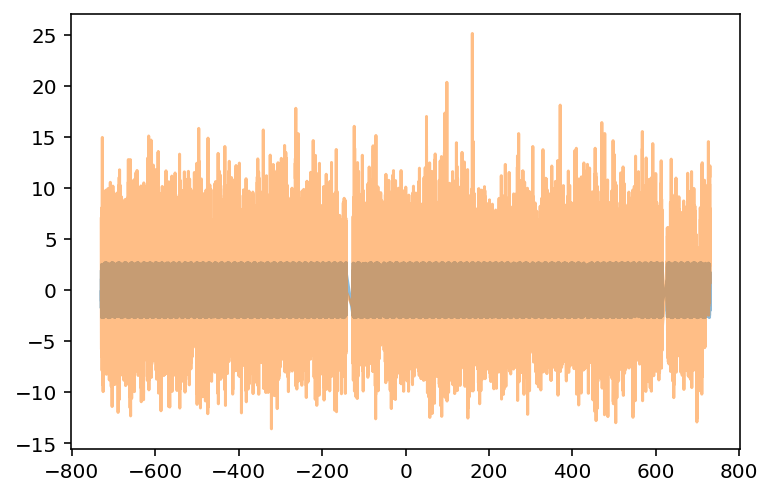

In [29]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
    map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
    map_params = xo.optimize(start=map_params, vars=[phase, logamp])
    #map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[logasini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=all_but)

#     map_params = xo.optimize(start=map_params)

    plt.plot(time, xo.eval_in_model(lc_model, map_params), alpha=0.5)
    plt.plot(time, mag, alpha=0.5)

In [57]:
map_params

{'logP_interval__': array(-1.03121554),
 'phi_angle__': array([-3.79191577, -2.37094388]),
 'logs_lc': array(-1.30812392),
 'logasini_interval__': array(-0.60801949),
 'mean': array(0.00798465),
 'lognu': array([2.65237127, 2.5979628 ]),
 'phase_angle__': array([[ 3.30153609, -2.93128102],
        [-3.01659755,  3.37751281]]),
 'logamp_interval__': array([ 0.59810561, -0.44808984]),
 'logw0_interval__': array(1.27172436),
 'logpower': array(10.82300999),
 'logP': array(2.21466898),
 'period': array(9.15837702),
 'phi': array(-2.1295846),
 'logasini': array(2.86992984),
 'asini': array(17.63578083),
 'nu': array([14.18764155, 13.43633764]),
 'phase': array([ 2.3111265 , -0.71478405]),
 'logamp': array([ 0.54925686, -0.03884124]),
 'logw0': array(2.62792478),
 'logS0': array(0.31131088)}

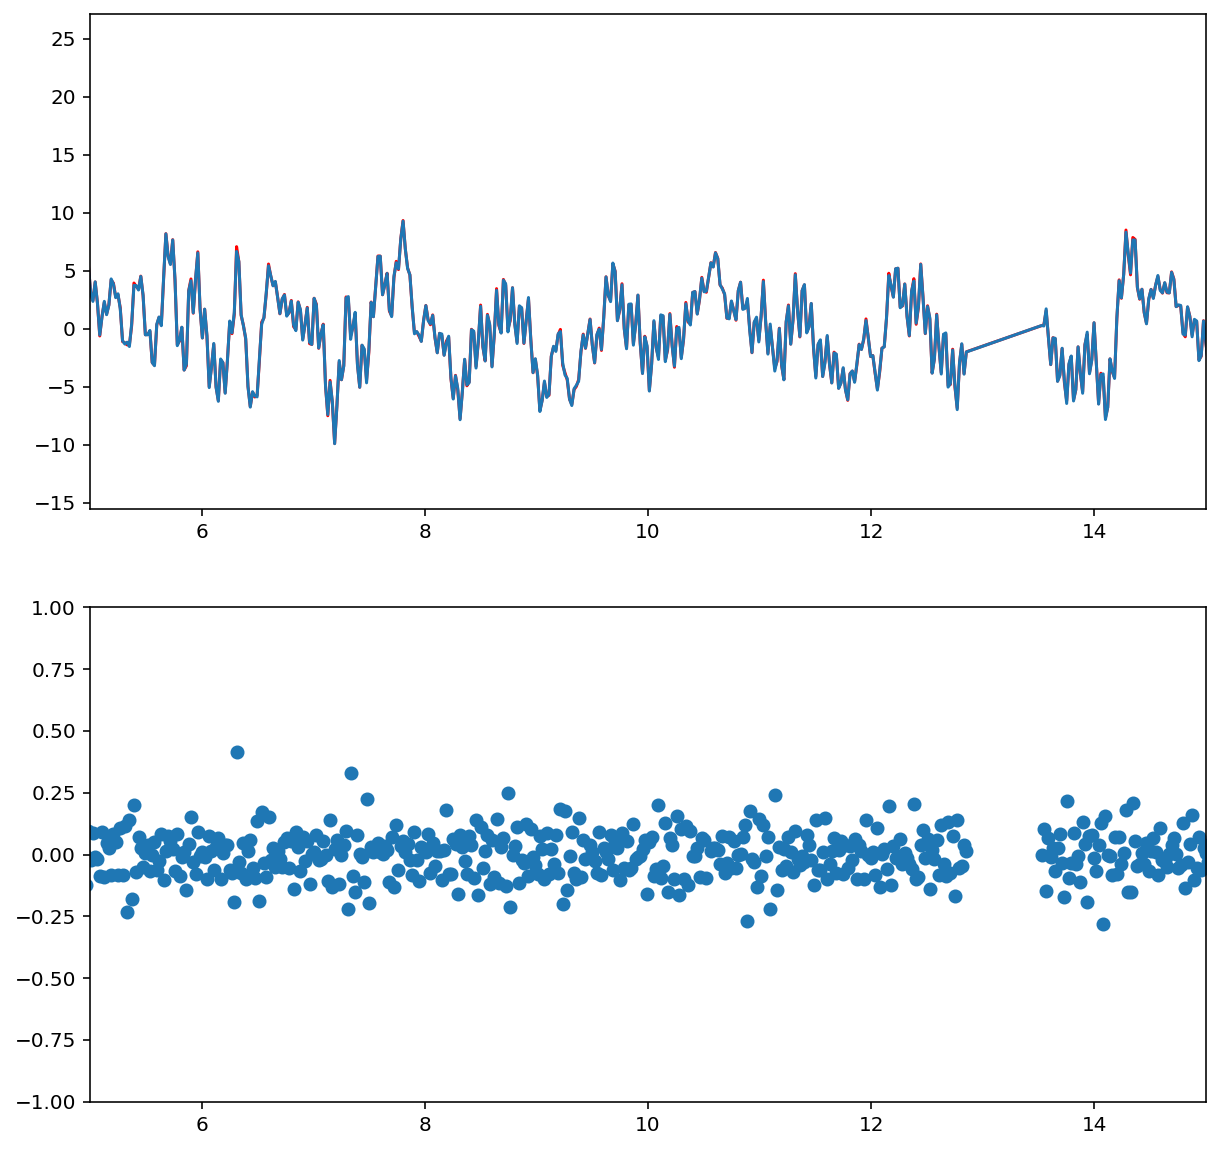

In [36]:
fig, axes = plt.subplots(2,1, figsize=[10,10])

with model:
    ax = axes[0]
    ax.plot(time, mag, c='r')
    #plt.plot(time, xo.eval_in_model(full_lc, map_params))
    ax.plot(time, xo.eval_in_model(full_lc + gp.predict(), map_params))
    ax.set_xlim(5, 15)
    
    ax = axes[1]
    ax.scatter(time, mag - xo.eval_in_model(full_lc + gp.predict(), map_params))
    ax.set_xlim(5, 15)
    ax.set_ylim(-1,1)

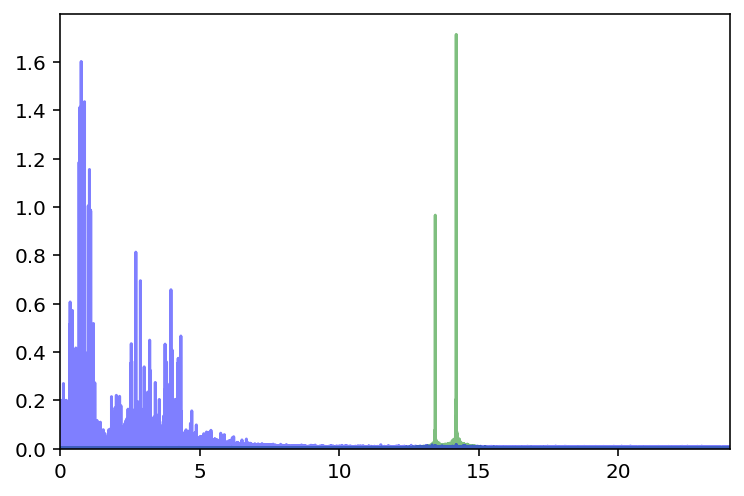

In [45]:
from maelstrom.utils import amplitude_spectrum

with model:
    #plt.plot(*amplitude_spectrum(time, mag), c='r', alpha=0.25)
    plt.plot(*amplitude_spectrum(time, xo.eval_in_model(full_lc, map_params)), c='g', alpha=0.5)
    plt.plot(*amplitude_spectrum(time, xo.eval_in_model(gp.predict(), map_params)), c='b', alpha=0.5)
    plt.xlim(0,24)
    plt.ylim(0, None)

In [68]:
ms.freq

array([14.18764197, 13.43633836])

In [31]:
sampler = xo.PyMC3Sampler(window=200, finish=500)
with model:
    burnin = sampler.tune(tune=1000, step_kwargs=dict(target_accept=0.9), start=map_params)

Sampling 2 chains: 100%|██████████| 1004/1004 [02:42<00:00,  4.60draws/s]


In [59]:
with model:
    trace = sampler.sample(draws=2000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [logpower, logw0, logamp, phase, lognu, mean, logasini, logs_lc, phi, logP]
>NUTS: [logpower, logw0, logamp, phase, lognu, mean, logasini, logs_lc, phi, logP]
Sampling 2 chains: 100%|██████████| 4000/4000 [10:46<00:00,  5.24draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.


In [33]:
np.quantile(trace['period'], [0.025])

array([9.15318972])

In [62]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logs_lc,-1.247794,5.439017e-03,6.105413e-05,-1.258181,-1.236137,7571.766865,1.000225
mean,0.070430,7.311742e-01,8.140174e-03,-1.351437,1.494433,7517.237639,0.999846
lognu__0,2.652371,3.366760e-08,3.734249e-10,2.652371,2.652371,7199.236264,1.000176
lognu__1,2.597963,6.550431e-08,6.781914e-10,2.597963,2.597963,9376.108848,0.999750
logpower,10.555172,8.773869e-03,9.922879e-05,10.538794,10.572772,7250.681165,0.999824
logP,2.214674,2.899370e-04,3.367568e-06,2.214109,2.215233,7581.757651,0.999826
period,9.158419,2.655380e-03,3.084405e-05,9.153248,9.163546,7581.202555,0.999826
phi,-2.129096,8.195601e-02,9.459045e-04,-2.293299,-1.973237,7762.872641,1.000033
logasini,2.886284,8.427796e-02,1.114764e-03,2.714231,3.046064,6095.014619,0.999796
asini,17.989675,1.495739e+00,1.912765e-02,15.093000,21.032404,6531.483343,0.999816


In [48]:
2.667342e-03

0.002667342

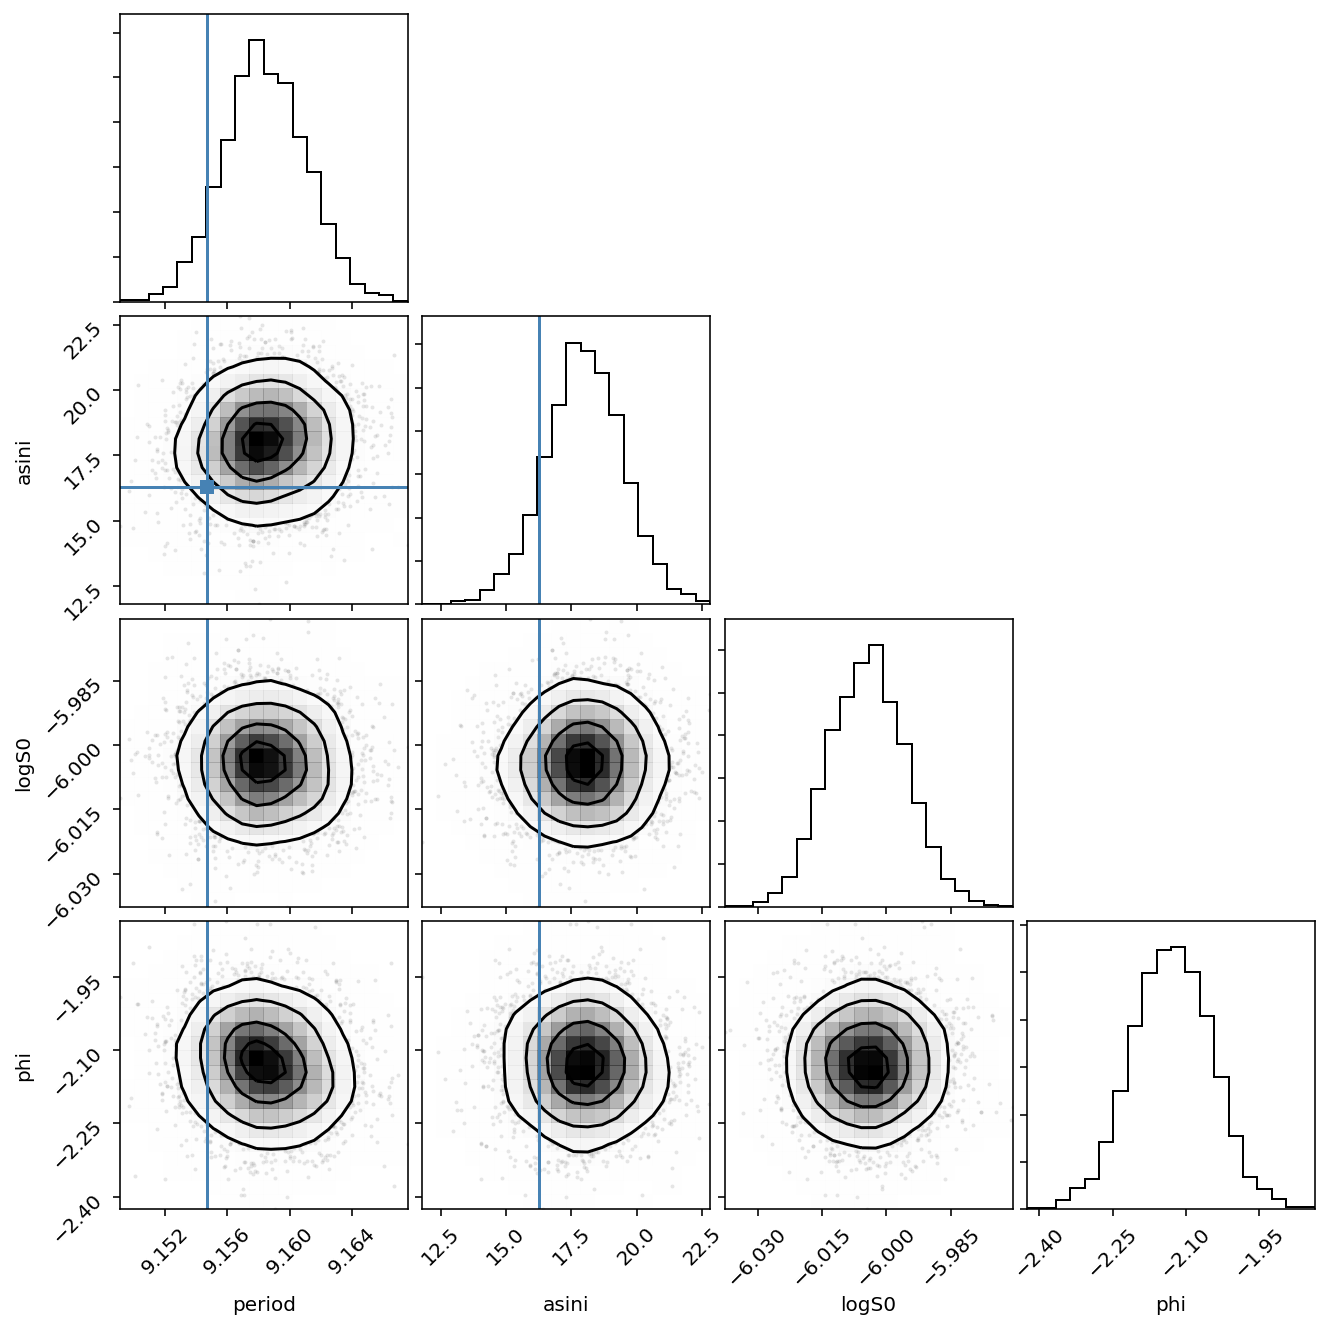

In [70]:
import corner

samples = pm.trace_to_dataframe(trace, 
                                varnames=['period', 'asini', 'logS0', 'phi']
                                #[v.name for v in model.vars]
                               )
for k in samples.columns:
    if "_" in k:
        samples[k.replace("_", "")] = samples[k]
        del samples[k]
        
corner.corner(samples, smooth=1, truths=[9.1547, 16.278, 0, 0,]);

In [63]:
from maelstrom.utils import mass_function
import astropy.units as u
mf = mass_function(trace['period'] * u.day, trace['asini'] * u.s)

In [64]:
np.mean(mf)

<Quantity 0.07606769 solMass>

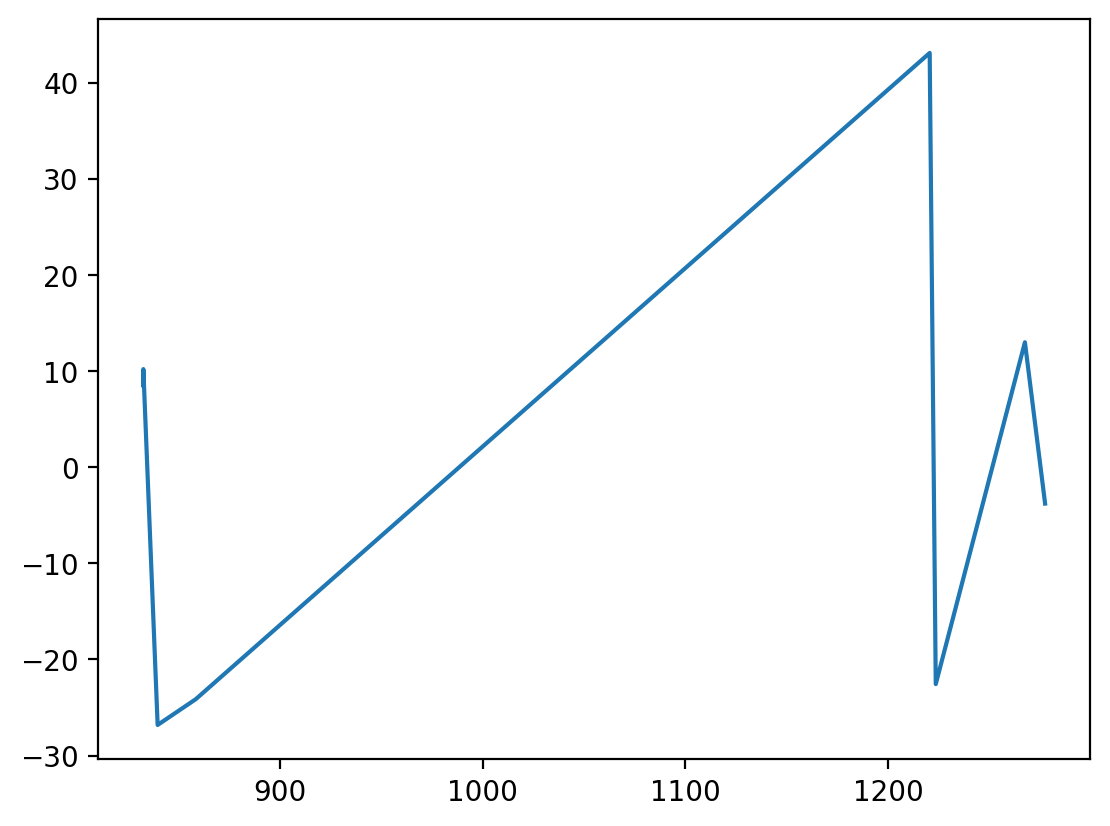

In [6]:
rv_jd, rv_rv, rv_err = np.loadtxt('data/kic6780873_JDrv.txt', delimiter=',', usecols=(0,1,2)).T
rv_jd += 2400000
rv_jd -= 2454833
rv_jd -= ms.time_mid
plt.plot(rv_jd, rv_rv)

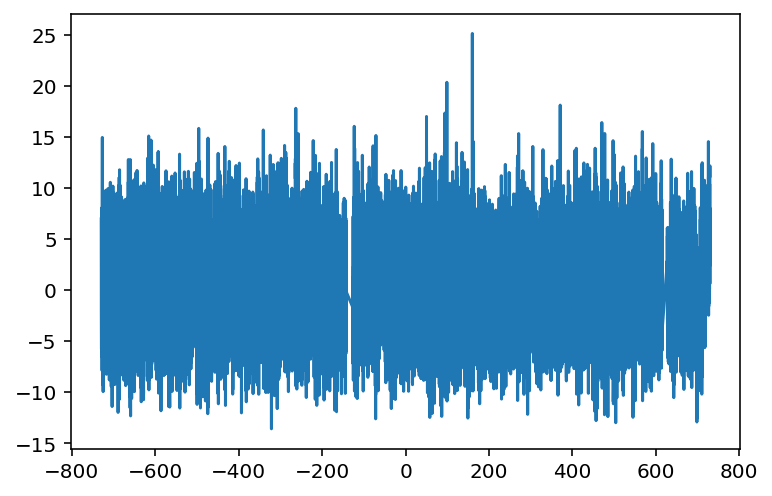

In [12]:
plt.plot(time, mag)

In [ ]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import pymc3 as pm

with pm.Model() as model_with_eccen:
    # It's much faster to sample from a log-space period
#     logP = pm.Normal("logP", mu=np.log(9.15), sd=3.)
    logP = pm.Bound(pm.Normal,
                    lower=np.log(5),
                    upper=np.log(50))("logP", mu=np.log(9.15), sd=1.0,
                                      testval=np.log(9.15))
    period = pm.Deterministic("period", pm.math.exp(logP))
    # Time delay drift
    drift_gradient = 0.0
#     drift_gradient = pm.Normal('drift_grad', mu=0.0, sd=0.01, shape=len(freq))
    
    # The time of conjunction
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(mag)), sd=10, testval=0.)
    logasini = pm.Bound(pm.Normal,
                        lower=np.log(10),
                        upper=np.log(50))('logasini', mu=np.log(19.6), sd=1,
                                            testval=np.log(19.6))
    asini = pm.Deterministic("asini", tt.exp(logasini))
    
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)
    
    # Mean anom
    M = 2.0 * np.pi * time / period - phi
    psi = -tt.sin(M)
    
    # Sampling in the weights parameter is faster than solving the matrix.
    lognu = pm.Normal("lognu", mu=np.log(ms.freq), sd=0.1, shape=len(ms.freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    factor = 2. * np.pi * nu
    
    arg = ((factor * (1 - drift_gradient))[None, :] * time[:, None]
           - (factor * asini / 86400)[None, :] * psi[:, None])

    phase = xo.distributions.Angle("phase", shape=len(ms.freq))
    log_min_amp = np.log(0.1 * np.std(mag))  # np.log(np.median(np.abs(np.diff(mag))))
    log_max_amp = np.log(np.std(mag))
    log_mean_amp = 0.5*(log_min_amp + log_max_amp)
    logamp = pm.Bound(pm.Normal,
                      lower=log_min_amp,
                      upper=log_max_amp)("logamp", mu=log_mean_amp, sd=10.0, shape=len(freq),
                                         testval=log_mean_amp)
    lc_model = tt.sum(tt.exp(logamp)[None, :] * tt.sin(arg - phase[None, :]), axis=1)
        
    # GP parameters
    logw0 = pm.Bound(pm.Normal,
                     lower=np.log(2*np.pi/100.0),
                     upper=np.log(2*np.pi/0.1))("logw0", mu=np.log(2*np.pi/10), sd=10,
                                                testval=np.log(2*np.pi/10))
    logpower = pm.Normal("logpower", mu=np.log(np.var(mag)), sd=10)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    full_lc = lc_model + mean

    pm.Potential("obs", gp.log_likelihood(mag - full_lc))
#     pm.Deterministic("gp_pred", gp.predict())

    #trace = pm.load_trace(directory='traces/6780873/')
    
    # RADIAL VELOCITIES
    logs_rv = pm.Normal('logs_RV_a', mu=0., sd=10)
    rv_mean_anom = (2.0 * np.pi * rv_jd / period - phi)
            rv_true_anom = get_true_anomaly(rv_mean_anom, eccen + tt.zeros_like(rv_mean_anom))